## Setup and Import Data (Bronze Layer)

In [1]:
from pymongo import MongoClient
import pandas as pd

# Loading dataset
data = pd.read_csv("realtor-data.csv")
print(f"Dataset Loaded: {data.shape[0]} rows and {data.shape[1]} columns")

# Connecting to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["realtor_db"]
collection = db["realtor_data"]

# Inserting data into MongoDB
data_dict = data.to_dict("records")
collection.insert_many(data_dict)
print(f"Data Inserted into MongoDB: {collection.count_documents({})} records")

Dataset Loaded: 1048575 rows and 12 columns
Data Inserted into MongoDB: 1048575 records


## Clean the Data (Silver Layer)

In [19]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Before datacleaning:")
print(missing_values)

# Handling missing values column-wise
data["brokered_by"].fillna(value=0, inplace=True) 
data["status"].fillna(value="Unknown", inplace=True)  
data["price"].fillna(data["price"].median(), inplace=True)  
data["bed"].fillna(data["bed"].median(), inplace=True)  
data["bath"].fillna(data["bath"].median(), inplace=True) 
data["acre_lot"].fillna(data["acre_lot"].median(), inplace=True)  
data["street"].fillna(value="Not Available", inplace=True)  
data["city"].fillna(value="Not Available", inplace=True)  
data["state"].fillna(value="Unknown", inplace=True)  
data["zip_code"].fillna(data["zip_code"].median(), inplace=True)  
data["house_size"].fillna(data["house_size"].median(), inplace=True)  
data["prev_sold_date"].fillna(value="Not Available", inplace=True)  

# Rechecking for missing values
missing_values_after = data.isnull().sum()
print("\nAfter datacleaning:")
print(missing_values_after)

# Save the cleaned data to MongoDB
collection_cleaned = db["realtor_data_cleaned"]
collection_cleaned.delete_many({})
collection_cleaned.insert_many(data.to_dict("records"))
print(f"Cleaned data inserted into MongoDB: {collection_cleaned.count_documents({})} records")

Before datacleaning:
brokered_by         5182
status              4144
price               5234
bed               313415
bath              328447
acre_lot          181554
street             10901
city                5003
state               4151
zip_code            4302
house_size        367815
prev_sold_date    553254
dtype: int64


C:\Users\phani\AppData\Local\Temp\ipykernel_26408\2647475232.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["brokered_by"].fillna(value=0, inplace=True)
C:\Users\phani\AppData\Local\Temp\ipykernel_26408\2647475232.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex


After datacleaning:
brokered_by       0
status            0
price             0
bed               0
bath              0
acre_lot          0
street            0
city              0
state             0
zip_code          0
house_size        0
prev_sold_date    0
dtype: int64
Cleaned data inserted into MongoDB: 1048575 records


In [5]:
# Step 3: MongoDB Data Type Conversion
# Update the fields to convert them to double (numeric type) in MongoDB
collection.update_many(
    {"price": {"$type": "string"}},  # If price is a string
    [{"$set": {"price": {"$toDouble": "$price"}}}]
)

collection.update_many(
    {"bed": {"$type": "string"}},  # If bed is a string
    [{"$set": {"bed": {"$toDouble": "$bed"}}}]
)

collection.update_many(
    {"bath": {"$type": "string"}},  # If bath is a string
    [{"$set": {"bath": {"$toDouble": "$bath"}}}]
)

collection.update_many(
    {"acre_lot": {"$type": "string"}},  # If acre_lot is a string
    [{"$set": {"acre_lot": {"$toDouble": "$acre_lot"}}}]
)

collection.update_many(
    {"house_size": {"$type": "string"}},  # If house_size is a string
    [{"$set": {"house_size": {"$toDouble": "$house_size"}}}]
)

# Optional: Convert other fields to the correct types if needed
# E.g., If zip_code is stored as a string, convert it to a number
collection.update_many(
    {"zip_code": {"$type": "string"}},
    [{"$set": {"zip_code": {"$toDouble": "$zip_code"}}}]
)

print("Data types converted in MongoDB.")

Data types converted in MongoDB.


## Create Aggregated Datasets (Gold Layer)

In [7]:
# Average property price by city
pipeline_avg_price_by_city = [
    {"$group": {"_id": "$city", "average_price": {"$avg": "$price"}}},
    {"$sort": {"average_price": -1}}
]

average_price_by_city = list(collection_cleaned.aggregate(pipeline_avg_price_by_city))
print("Average Property Price by City:")
for record in average_price_by_city[:10]:  # Display top 10 results
    print(f"City: {record['_id']}, Average Price: ${record['average_price']:.2f}")

Average Property Price by City:
City: International, Average Price: $2147483600.00
City: Campo, Average Price: $45000000.00
City: Wayne City, Average Price: $43386633.33
City: Jolly, Average Price: $17900000.00
City: Golden Oak, Average Price: $16385000.00
City: South Fork Lodgepole Rd, Average Price: $15000000.00
City: Golden Beach, Average Price: $14307142.86
City: Sagaponack, Average Price: $13649833.33
City: Gulf Stream, Average Price: $12116750.00
City: Waterfront, Average Price: $12000000.00


In [9]:
# Total number of properties by state
pipeline_total_properties_by_state = [
    {"$group": {"_id": "$state", "total_properties": {"$sum": 1}}},
    {"$sort": {"total_properties": -1}}
]

total_properties_by_state = list(collection_cleaned.aggregate(pipeline_total_properties_by_state))
print("\nTotal Number of Properties by State:")
for record in total_properties_by_state[:10]:  # Display top 10 results
    print(f"State: {record['_id']}, Total Properties: {record['total_properties']}")


Total Number of Properties by State:
State: Florida, Total Properties: 163840
State: New York, Total Properties: 67689
State: North Carolina, Total Properties: 58283
State: Illinois, Total Properties: 53432
State: Georgia, Total Properties: 52030
State: Pennsylvania, Total Properties: 48881
State: Texas, Total Properties: 40111
State: Ohio, Total Properties: 37972
State: Tennessee, Total Properties: 36650
State: Michigan, Total Properties: 36336


In [11]:
# Average house size by state
pipeline_avg_house_size_by_state = [
    {"$group": {"_id": "$state", "average_house_size": {"$avg": "$house_size"}}},
    {"$sort": {"average_house_size": -1}}
]

average_house_size_by_state = list(collection_cleaned.aggregate(pipeline_avg_house_size_by_state))
print("\nAverage House Size by State:")
for record in average_house_size_by_state[:10]:  # Display top 10 results
    print(f"State: {record['_id']}, Average House Size: {record['average_house_size']:.2f} sqft")


Average House Size by State:
State: California, Average House Size: 2843.50 sqft
State: Puerto Rico, Average House Size: 2584.36 sqft
State: Minnesota, Average House Size: 2291.12 sqft
State: Virgin Islands, Average House Size: 2262.14 sqft
State: Massachusetts, Average House Size: 2197.28 sqft
State: Montana, Average House Size: 2172.99 sqft
State: Virginia, Average House Size: 2170.77 sqft
State: Texas, Average House Size: 2170.49 sqft
State: Connecticut, Average House Size: 2165.78 sqft
State: Georgia, Average House Size: 2156.30 sqft


In [13]:
#Total properties by status
pipeline_total_properties_by_status = [
    {"$group": {"_id": "$status", "total_properties": {"$sum": 1}}},
    {"$sort": {"total_properties": -1}}
]

total_properties_by_status = list(collection_cleaned.aggregate(pipeline_total_properties_by_status))
print("\nTotal Properties by Status:")
for record in total_properties_by_status:
    print(f"Status: {record['_id']}, Total Properties: {record['total_properties']}")


Total Properties by Status:
Status: for_sale, Total Properties: 1027462
Status: ready_to_build, Total Properties: 16969
Status: Unknown, Total Properties: 4144


In [15]:
# Find average price of all properties
average_price = collection_cleaned.aggregate([
    {"$group": {"_id": None, "average_price": {"$avg": "$price"}}}
])
average_price_value = list(average_price)[0]["average_price"]

# Properties priced above the overall average
pipeline_properties_above_avg_price = [
    {"$match": {"price": {"$gt": average_price_value}}},
    {"$project": {"city": 1, "state": 1, "price": 1, "_id": 0}},
    {"$sort": {"price": -1}}
]

properties_above_avg_price = list(collection_cleaned.aggregate(pipeline_properties_above_avg_price))
print("\nProperties Above Average Price:")
for record in properties_above_avg_price[:10]:  # Display top 10 high-value properties
    print(f"City: {record['city']}, State: {record['state']}, Price: ${record['price']:.2f}")


Properties Above Average Price:
City: International, State: California, Price: $2147483600.00
City: Eureka, State: Kansas, Price: $1000000000.00
City: Bronx, State: New York, Price: $875000000.00
City: Atlanta, State: Georgia, Price: $281500000.00
City: New York City, State: New York, Price: $169000000.00
City: Union City, State: Georgia, Price: $162627000.00
City: Miami, State: Florida, Price: $150000000.00
City: Palm Beach, State: Florida, Price: $150000000.00
City: New York, State: New York, Price: $135000000.00
City: Wayne City, State: Illinois, Price: $129900000.00


C:\Users\phani\AppData\Local\Temp\ipykernel_4484\1781551128.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="coolwarm")


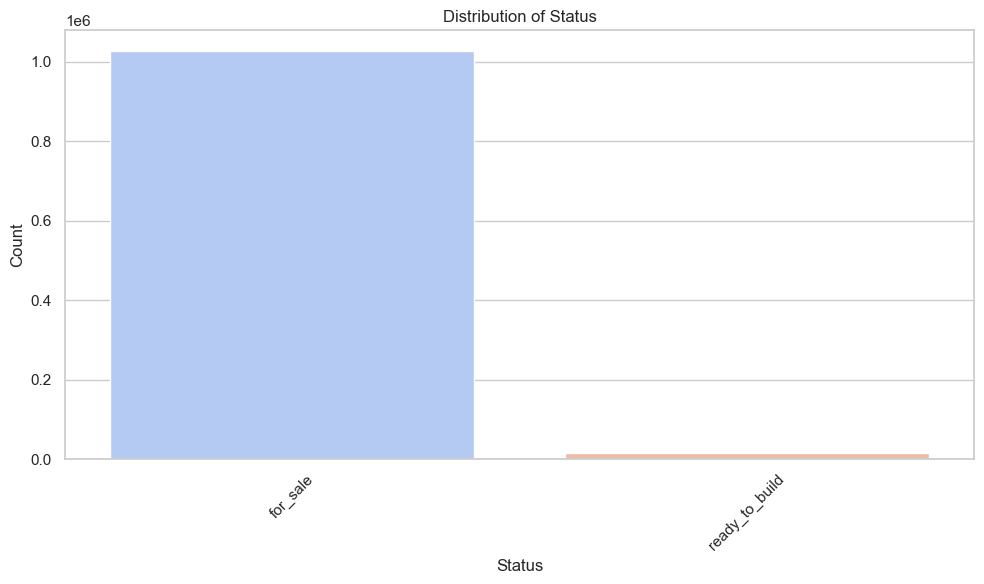

C:\Users\phani\AppData\Local\Temp\ipykernel_4484\1781551128.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="viridis")


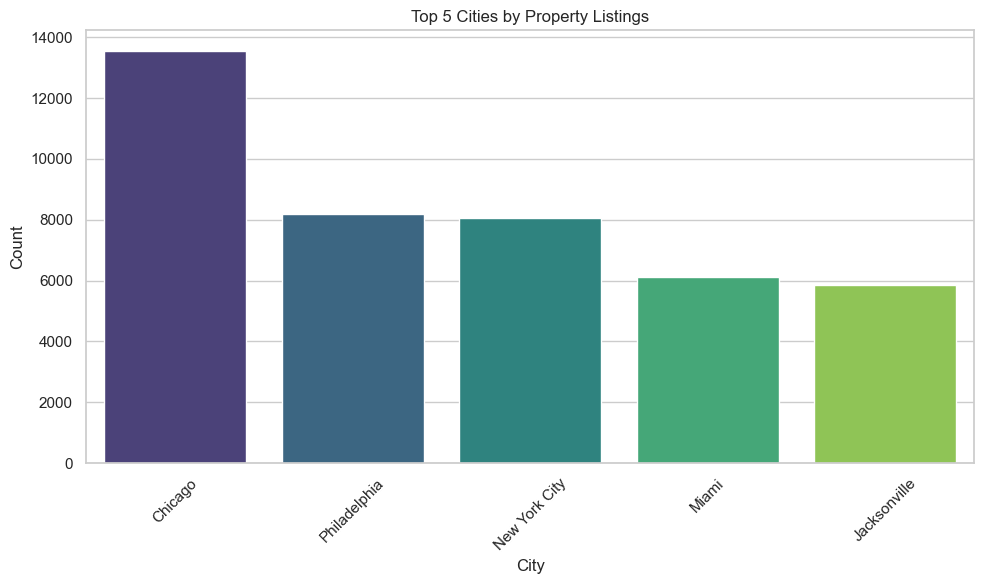

C:\Users\phani\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


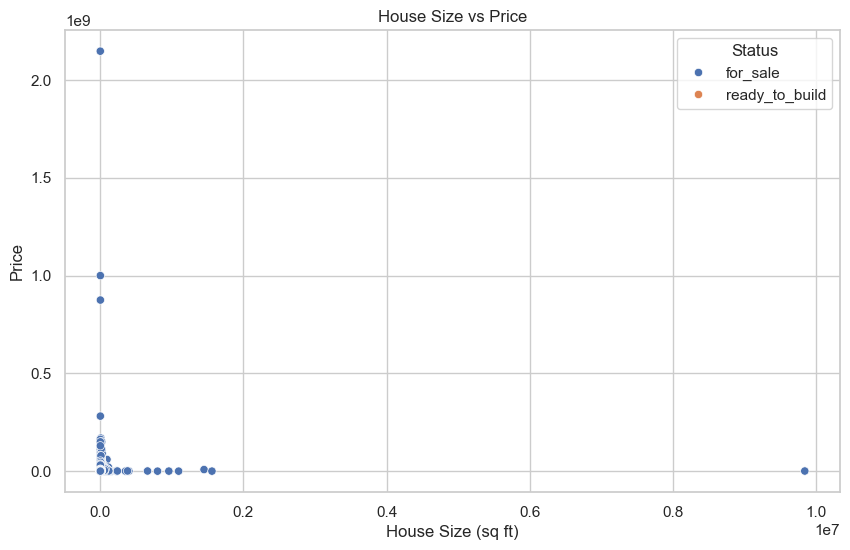

C:\Users\phani\AppData\Local\Temp\ipykernel_4484\1781551128.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="cool")


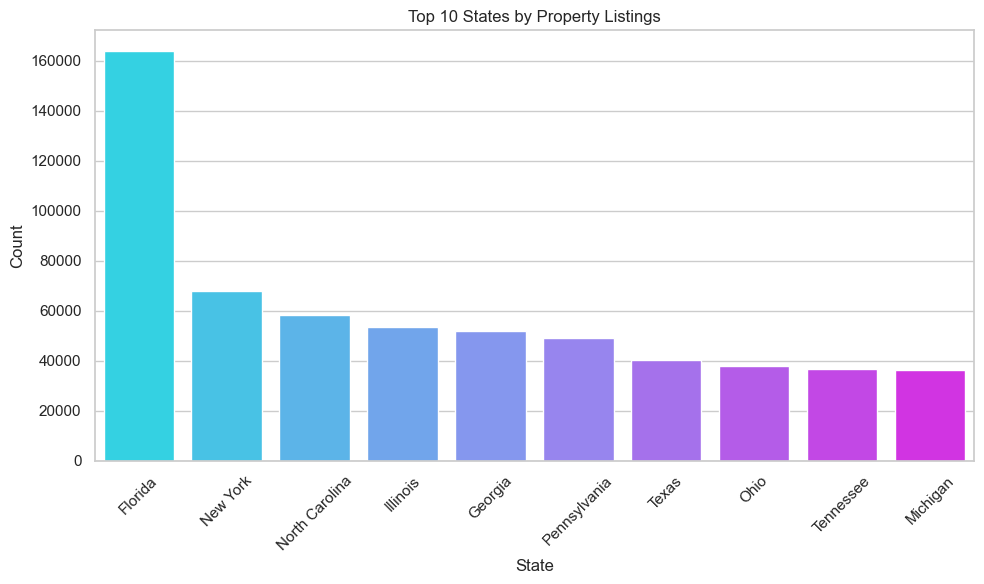

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for visualizations
sns.set_theme(style="whitegrid")


# 4. Status Distribution
plt.figure(figsize=(10, 6))
status_counts = data['status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette="coolwarm")
plt.title('Distribution of Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Top 5 Cities by Frequency
city_counts = data['city'].value_counts().head(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=city_counts.index, y=city_counts.values, palette="viridis")
plt.title('Top 5 Cities by Property Listings')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Price vs House Size
plt.figure(figsize=(10, 6))
sns.scatterplot(x='house_size', y='price', hue='status', data=data, palette="deep")
plt.title('House Size vs Price')
plt.xlabel('House Size (sq ft)')
plt.ylabel('Price')
plt.legend(title='Status')
plt.grid(True)
plt.show()

# 7. State Distribution
plt.figure(figsize=(10, 6))
state_counts = data['state'].value_counts().head(10)
sns.barplot(x=state_counts.index, y=state_counts.values, palette="cool")
plt.title('Top 10 States by Property Listings')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


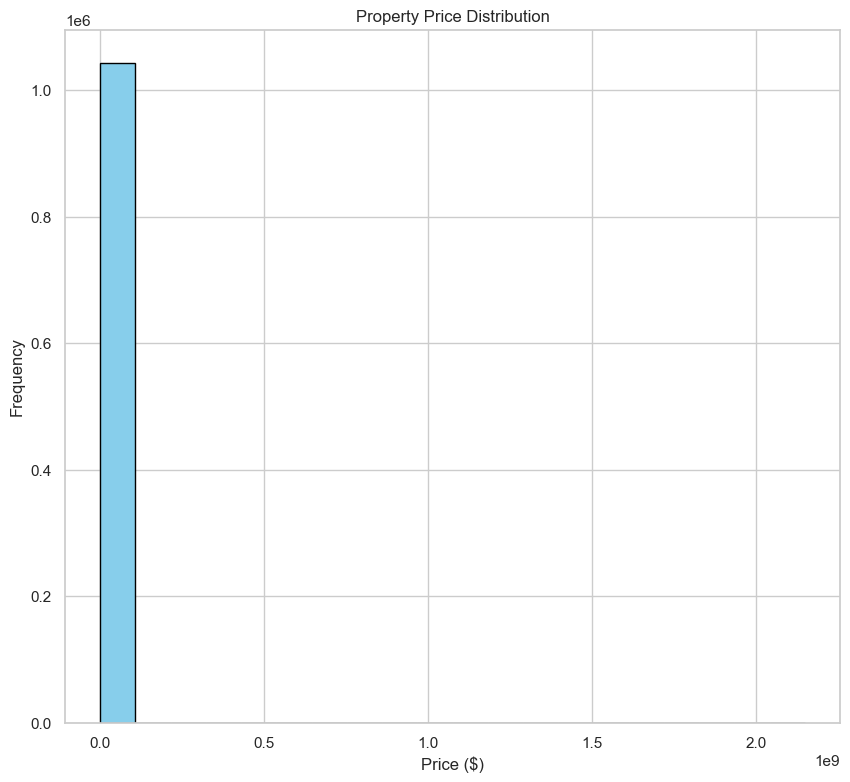

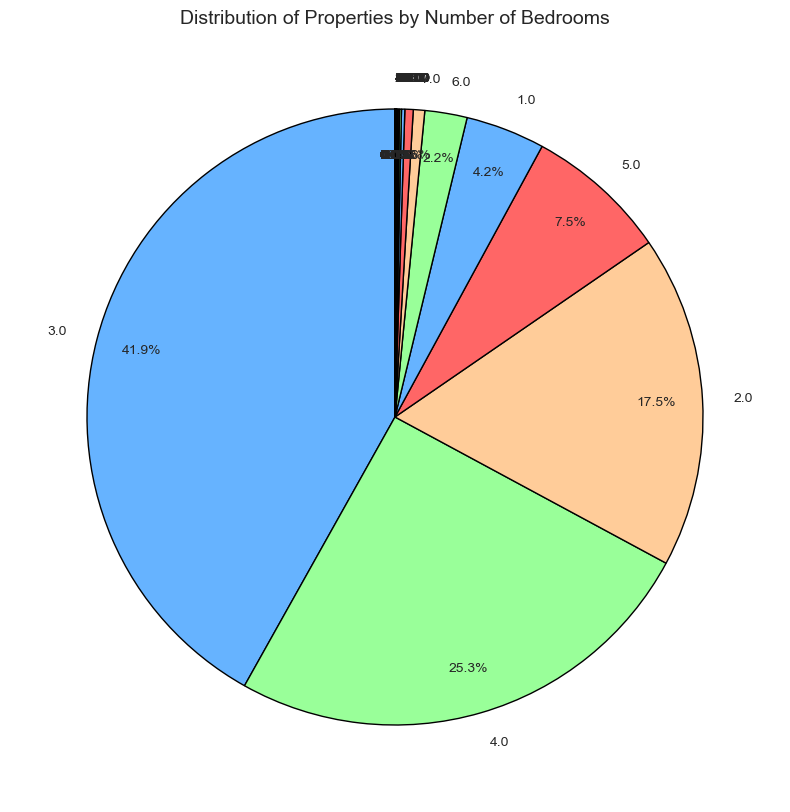

In [119]:
import matplotlib.pyplot as plt
import pandas as pd

# Load dataset
df = pd.read_csv('realtor-data.csv')

# Create the histogram
plt.figure(figsize=(10,9))
plt.hist(df['price'], bins=20, color='skyblue', edgecolor='black')
plt.title('Property Price Distribution')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()



# Calculate the count of properties by number of bedrooms
bedroom_count = df['bed'].value_counts()

# Create the pie chart
plt.figure(figsize=(10, 10))
wedges, texts, autotexts = plt.pie(bedroom_count, labels=bedroom_count.index, autopct='%1.1f%%', startangle=90, 
                                   colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'], 
                                   pctdistance=0.85, labeldistance=1.1, 
                                   wedgeprops={'edgecolor': 'black', 'linewidth': 1})

# Set the font size for the text inside the pie chart
for text in texts:
    text.set_fontsize(10)  # Adjust label font size (the text in the slices)
for autotext in autotexts:
    autotext.set_fontsize(10)  # Adjust percentage font size (the percentages in the slices)

# Set the title with smaller font size
plt.title('Distribution of Properties by Number of Bedrooms', fontsize=14)

plt.show()
